# Task 2 Extention?
### Trying to get to the minimum faster than Gauss-Newton method

Solution found at [1.         0.99999999] with value 2.7456487587636984e-17 in 34 iterations.


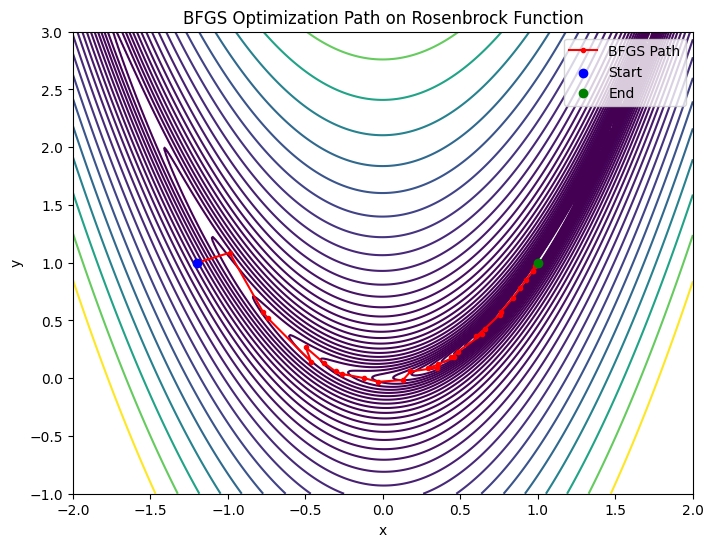

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Rosenbrock function
def rosenbrock(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

# Gradient of the Rosenbrock function
def gradient(x):
    grad_x = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    grad_y = 200 * (x[1] - x[0]**2)
    return np.array([grad_x, grad_y])

# BFGS optimization algorithm
def bfgs_with_plot(x0, tol=1e-6, max_iter=100):
    n = len(x0)
    B = np.eye(n)  # Initial Hessian approximation
    x = x0
    grad = gradient(x)
    iter_count = 0

    # Track the optimization path
    path = [x.copy()]

    while np.linalg.norm(grad) > tol and iter_count < max_iter:
        # Search direction
        p = -np.linalg.solve(B, grad)

        # Line search for step size (simple backtracking)
        alpha = 1.0
        while rosenbrock(x + alpha * p) > rosenbrock(x) + 1e-4 * alpha * np.dot(grad, p):
            alpha *= 0.5

        # Update position
        x_new = x + alpha * p
        grad_new = gradient(x_new)

        # Compute s and y
        s = x_new - x
        y = grad_new - grad

        # Update Hessian approximation using the BFGS formula
        ys = np.dot(y, s)
        if ys > 0:  # Avoid division by zero or negative curvature
            B = B + np.outer(y, y) / ys - np.dot(B @ np.outer(s, s), B) / np.dot(s, B @ s)

        # Prepare for next iteration
        x = x_new
        grad = grad_new
        iter_count += 1
        path.append(x.copy())

    return x, rosenbrock(x), iter_count, np.array(path)

# Visualization function
def plot_bfgs_path(path):
    # Generate a grid of Rosenbrock values
    x = np.linspace(-2, 2, 400)
    y = np.linspace(-1, 3, 400)
    X, Y = np.meshgrid(x, y)
    Z = 100 * (Y - X**2)**2 + (1 - X)**2

    plt.figure(figsize=(8, 6))
    plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 35), cmap='viridis')
    plt.plot(path[:, 0], path[:, 1], 'r.-', label="BFGS Path")
    plt.scatter(path[0, 0], path[0, 1], color='blue', label='Start', zorder=5)
    plt.scatter(path[-1, 0], path[-1, 1], color='green', label='End', zorder=5)
    plt.title("BFGS Optimization Path on Rosenbrock Function")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

# Run BFGS and plot
if __name__ == "__main__":
    x0 = np.array([-1.2, 1])  # Initial guess
    solution, min_value, iterations, path = bfgs_with_plot(x0)
    print(f"Solution found at {solution} with value {min_value} in {iterations} iterations.")
    plot_bfgs_path(path)



### Trying Task 2 but with Gauss-Newton vs BFGS

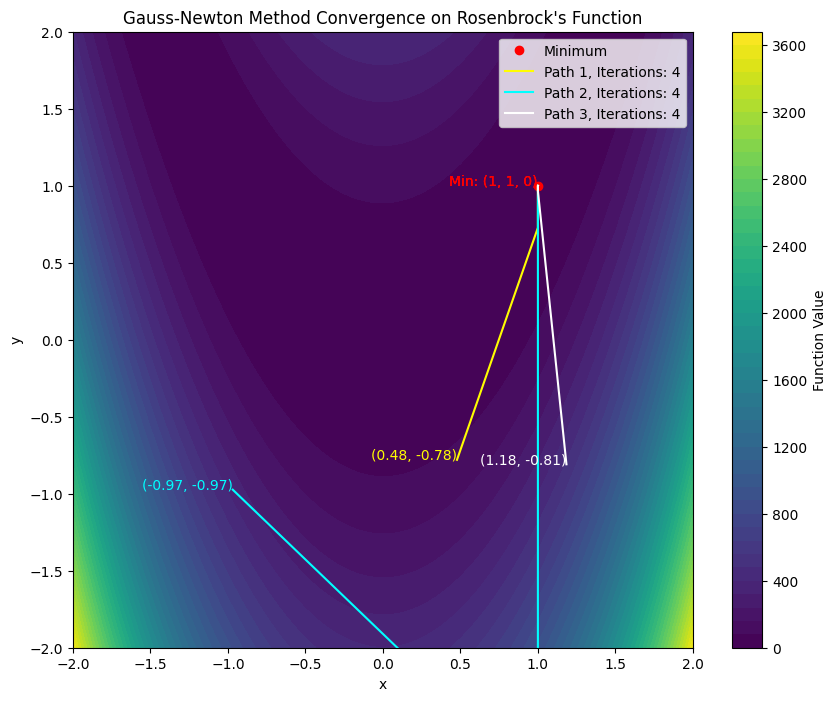

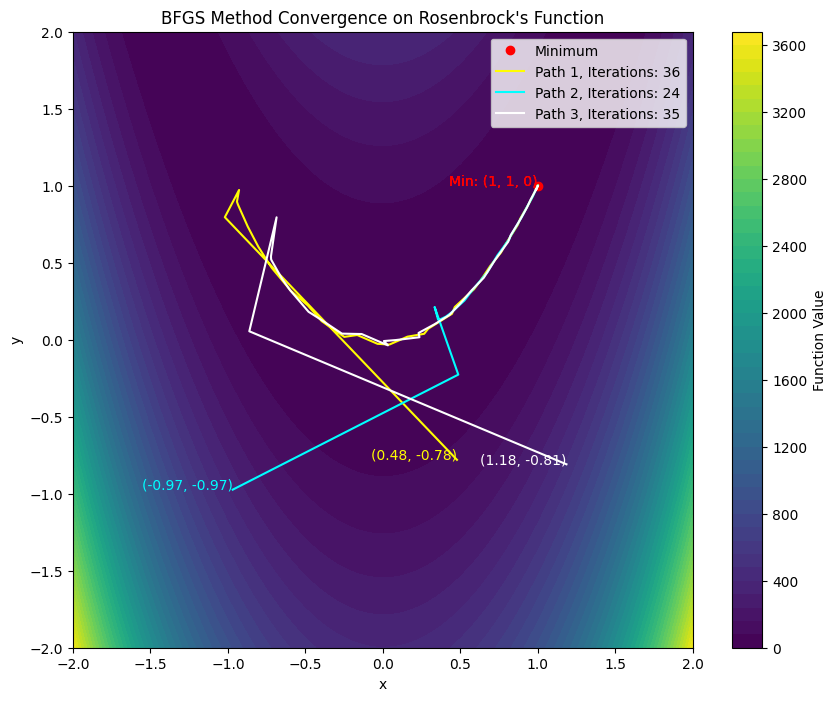

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Rosenbrock function, gradient, and Hessian
def rosenbrock(x, y):
    return 100 * (y - x**2)**2 + (1 - x)**2

def gradient(x, y):
    dfdx = -400 * x * (y - x**2) - 2 * (1 - x)
    dfdy = 200 * (y - x**2)
    return np.array([dfdx, dfdy])

# Gauss-Newton Method with damping factor for faster convergence
def gauss_newton_method(start_point, damping_factor=1e-9, max_iterations=9999, tolerance=1e-6):
    path = [np.array(start_point)]
    for _ in range(max_iterations):
        x, y = path[-1]
        
        # Define residuals for the Rosenbrock function
        r1 = 10 * (y - x**2)
        r2 = 1 - x
        residuals = np.array([r1, r2])  # (2,)
        
        # Define Jacobian of residuals
        J = np.array([[-20 * x, 10], [-1, 0]])  # (2, 2)
        
        # Compute damped J.T @ J to avoid instability
        J_damped = J.T @ J + damping_factor * np.eye(2)  # Add damping factor for stability
        
        # Update step with the damped version
        try:
            delta = np.linalg.inv(J_damped) @ J.T @ residuals  # Solve for step size
        except np.linalg.LinAlgError:
            break  # Exit if matrix inversion fails
        
        # Update position based on the step
        new_point = path[-1] - delta
        path.append(new_point)
        
        # Break if the update is small (convergence)
        if np.linalg.norm(delta) < tolerance:
            break
    
    return np.array(path)

# BFGS optimization algorithm
def bfgs_method(start_point, tol=1e-6, max_iterations=100):
    n = len(start_point)
    B = np.eye(n)  # Initial Hessian approximation
    x = np.array(start_point)
    grad = gradient(*x)
    path = [x.copy()]

    for _ in range(max_iterations):
        if np.linalg.norm(grad) < tol:
            break

        # Search direction
        p = -np.linalg.solve(B, grad)

        # Line search for step size (simple backtracking)
        alpha = 1.0
        while rosenbrock(*(x + alpha * p)) > rosenbrock(*x) + 1e-4 * alpha * np.dot(grad, p):
            alpha *= 0.5

        # Update position
        x_new = x + alpha * p
        grad_new = gradient(*x_new)

        # Compute s and y
        s = x_new - x
        y = grad_new - grad

        # Update Hessian approximation using the BFGS formula
        ys = np.dot(y, s)
        if ys > 0:  # Avoid division by zero or negative curvature
            B = B + np.outer(y, y) / ys - np.dot(B @ np.outer(s, s), B) / np.dot(s, B @ s)

        # Update variables for next iteration
        x = x_new
        grad = grad_new
        path.append(x.copy())

    return np.array(path)

# Create a grid for the contour plot
x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosenbrock(X, Y)

# Updated function to correctly overlay paths on the Rosenbrock function
def plot_grouped(method_name, paths, colors, start_points, iterations_list):
    plt.figure(figsize=(10, 8))
    contour_filled = plt.contourf(X, Y, Z, levels=50, cmap="viridis")  # Correct Rosenbrock function domain
    plt.colorbar(contour_filled, label="Function Value")  # Color bar added
    plt.plot(1, 1, 'ro', label="Minimum")  # Highlight minimum
    for i, path in enumerate(paths):
        # Plot optimization paths
        plt.plot(path[:, 0], path[:, 1], color=colors[i], label=f"Path {i+1}, Iterations: {iterations_list[i]}")
        # Annotate starting points with coordinate values
        plt.text(1, 1, f"Min: (1, 1, 0)", color='red', fontsize=10, ha='right')
        plt.text(start_points[i][0], start_points[i][1], 
                 f"({start_points[i][0]:.2f}, {start_points[i][1]:.2f})",
                 color=colors[i], fontsize=10, ha='right')
    plt.title(f"{method_name} Convergence on Rosenbrock's Function")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-2, 2])  # Ensure correct domain
    plt.ylim([-2, 2])  # Ensure correct domain
    plt.legend()
    plt.show()

# Random initialization
start_points = [np.random.uniform(-2, 2, 2) for _ in range(3)]  # 3 random initializations
colors = ['xkcd:bright yellow', 'xkcd:cyan', 'xkcd:white']  # Colors for the paths

# Collect paths for each method
gn_paths = [gauss_newton_method(start_point) for start_point in start_points]
bfgs_paths = [bfgs_method(start_point) for start_point in start_points]

# Calculate the number of iterations for each path
gn_iterations = [len(path) for path in gn_paths]
bfgs_iterations = [len(path) for path in bfgs_paths]

# Plot grouped results with the number of iterations
plot_grouped("Gauss-Newton Method", gn_paths, colors, start_points, gn_iterations)
plot_grouped("BFGS Method", bfgs_paths, colors, start_points, bfgs_iterations)




### Plotting Them side by side

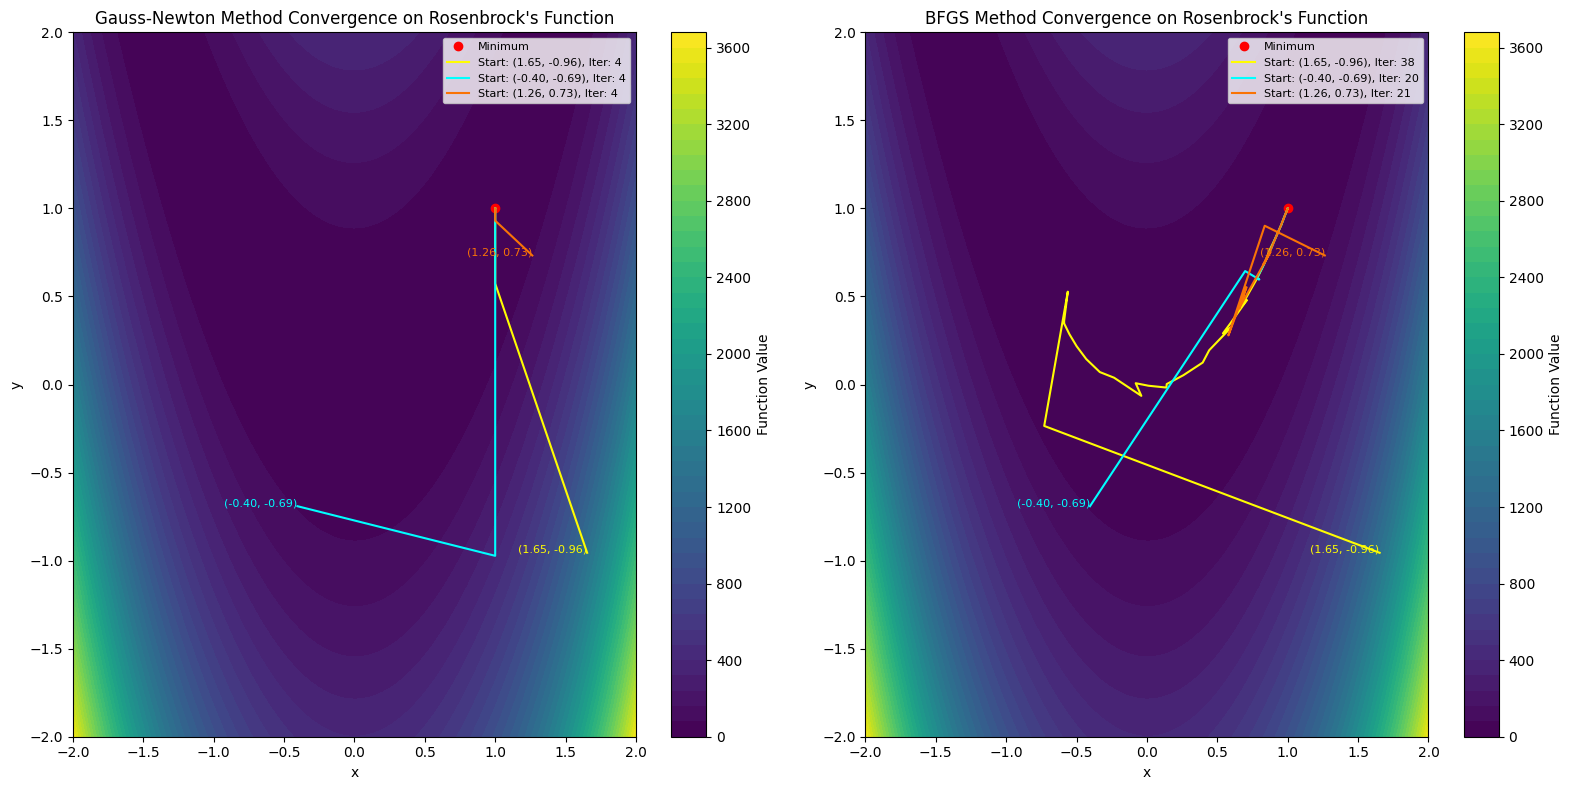

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Rosenbrock function, gradient, and Hessian
def rosenbrock(x, y):
    return 100 * (y - x**2)**2 + (1 - x)**2

def gradient(x, y):
    dfdx = -400 * x * (y - x**2) - 2 * (1 - x)
    dfdy = 200 * (y - x**2)
    return np.array([dfdx, dfdy])

# Gauss-Newton Method with damping factor for faster convergence
def gauss_newton_method(start_point, damping_factor=1e-9, max_iterations=9999, tolerance=1e-6):
    path = [np.array(start_point)]
    for _ in range(max_iterations):
        x, y = path[-1]
        
        # Define residuals for the Rosenbrock function
        r1 = 10 * (y - x**2)
        r2 = 1 - x
        residuals = np.array([r1, r2])  # (2,)
        
        # Define Jacobian of residuals
        J = np.array([[-20 * x, 10], [-1, 0]])  # (2, 2)
        
        # Compute damped J.T @ J to avoid instability
        J_damped = J.T @ J + damping_factor * np.eye(2)  # Add damping factor for stability
        
        # Update step with the damped version
        try:
            delta = np.linalg.inv(J_damped) @ J.T @ residuals  # Solve for step size
        except np.linalg.LinAlgError:
            break  # Exit if matrix inversion fails
        
        # Update position based on the step
        new_point = path[-1] - delta
        path.append(new_point)
        
        # Break if the update is small (convergence)
        if np.linalg.norm(delta) < tolerance:
            break
    
    return np.array(path)

# BFGS optimization algorithm
def bfgs_method(start_point, tol=1e-6, max_iterations=9999):
    n = len(start_point)
    B = np.eye(n)  # Initial Hessian approximation
    x = np.array(start_point)
    grad = gradient(*x)
    path = [x.copy()]

    for _ in range(max_iterations):
        if np.linalg.norm(grad) < tol:
            break

        # Search direction
        p = -np.linalg.solve(B, grad)

        # Line search for step size (simple backtracking)
        alpha = 1.0
        while rosenbrock(*(x + alpha * p)) > rosenbrock(*x) + 1e-4 * alpha * np.dot(grad, p):
            alpha *= 0.5

        # Update position
        x_new = x + alpha * p
        grad_new = gradient(*x_new)

        # Compute s and y
        s = x_new - x
        y = grad_new - grad

        # Update Hessian approximation using the BFGS formula
        ys = np.dot(y, s)
        if ys > 0:  # Avoid division by zero or negative curvature
            B = B + np.outer(y, y) / ys - np.dot(B @ np.outer(s, s), B) / np.dot(s, B @ s)

        # Update variables for next iteration
        x = x_new
        grad = grad_new
        path.append(x.copy())

    return np.array(path)

# Function to plot multiple iterations for each method on the same subplot
def plot_method(ax, method_name, paths, colors, start_points, iterations_list):
    contour_filled = ax.contourf(X, Y, Z, levels=50, cmap="viridis")  # Correct Rosenbrock function domain
    fig.colorbar(contour_filled, ax=ax, label="Function Value")  # Color bar added here using fig.colorbar
    ax.plot(1, 1, 'ro', label="Minimum")  # Highlight minimum
    
    # Plot paths for each initialization
    for path, color, start_point, iterations in zip(paths, colors, start_points, iterations_list):
        ax.plot(path[:, 0], path[:, 1], color=color, label=f"Start: ({start_point[0]:.2f}, {start_point[1]:.2f}), Iter: {iterations}")
        ax.text(start_point[0], start_point[1], 
                f"({start_point[0]:.2f}, {start_point[1]:.2f})", color=color, fontsize=8, ha='right')
    
    ax.set_title(f"{method_name} Convergence on Rosenbrock's Function")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim([-2, 2])  # Ensure correct domain
    ax.set_ylim([-2, 2])  # Ensure correct domain
    ax.legend(fontsize=8)

# Create a grid for the contour plot
x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosenbrock(X, Y)

# Random initialization
start_points = [np.random.uniform(-2, 2, 2) for _ in range(3)]  # 3 random initializations
colors = ['xkcd:bright yellow', 'xkcd:cyan', 'xkcd:orange']  # Colors for the paths

# Collect paths for each method
gn_paths = [gauss_newton_method(start_point) for start_point in start_points]
bfgs_paths = [bfgs_method(start_point) for start_point in start_points]

# Calculate the number of iterations for each path
gn_iterations = [len(path) for path in gn_paths]
bfgs_iterations = [len(path) for path in bfgs_paths]

# Create subplots to display the methods side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# Plot Gauss-Newton method
plot_method(axs[0], "Gauss-Newton Method", gn_paths, colors, start_points, gn_iterations)

# Plot BFGS method
plot_method(axs[1], "BFGS Method", bfgs_paths, colors, start_points, bfgs_iterations)

plt.tight_layout()
plt.show()
